In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import contextily as cx
from PIL import Image

from PlotsForPaper_Functions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.append("../ProcessModelResults/")
from my_functions import *

In [3]:
methods_dict = {'Idealised': ['6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4','6h_sp_c_0.5',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9'],
                'Observed':['6h_feh_singlepeak', '6h_c1','6h_c2','6h_c3','6h_c4', '6h_c5', '6h_c6','6h_c7',
             '6h_c8','6h_c9','6h_c10', '6h_c11', '6h_c12','6h_c13','6h_c14','6h_c15'], 
               'SinglePeak_Scaled':['6h_sp_+0%','6h_sp_+5%','6h_sp_+10%','6h_sp_+15%','6h_sp_+20%']}

## Plot catchments

In [4]:
methods_key ='Observed'
catchment_name = 'LinDyke'
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles_export/'.format(catchment_name, methods_key)

In [5]:
sys.path.append("../")
from my_functions import *

if catchment_name == 'LinDyke':
    catchment_name_str = "Resampled.Terrain" 
    catchment_shpfilename = 'CatchmentLinDyke_exported'
    minx, miny, maxx, maxy  = 437000,  426500,  445500, 434300
    catchment_gdf = gpd.read_file(model_directory + 'CatchmentLinDyke_exported.shp')
    
elif catchment_name == 'WykeBeck':
    catchment_name_str = "Terrain.wykeDEM" 
    catchment_shpfilename = 'WykeBeckCatchment'
    minx, miny, maxx, maxy = 430004,  429978, 438660, 440996
    catchment_gdf = gpd.read_file(model_directory + 'WykeBeckCatchment.shp')
    
# Create a bounding box (this is used in preparing the rasters)
bbox = box(minx, miny, maxx, maxy)

In [6]:
landcover_directory = '../../../FloodModelling/{}Models/LandCoverData/'.format(catchment_name)
# Water landcover classification - 10 is water, 11 is eveyrthing else
with rasterio.open(landcover_directory + 'LandCover_notwater_classification.tif', 'r') as ds:
    landcover_notwater = ds.read()[0]
    out_meta = ds.meta

In [28]:
# Create dictionaries to store results for each method
n_flooded_cells_dict = {}
n_flooded_cells_dict_over10cm = {}
n_flooded_cells_dict_notwater = {}

In [84]:
# # Create dictionaries to store results for each method
# n_flooded_cells_dict = {}
# n_flooded_cells_dict_over10cm = {}
# n_flooded_cells_dict_notwater = {}

# Loop through methods
#for method in methods_dict['Observed']:
for method in ['6h_c2', '6h_c3', '6h_c4', '6h_c5']:    
    print(method)
    
    # Create lists to store the values for each timeslice for this method
    n_flooded_cells = []
    n_flooded_cells_over10cm = []
    n_flooded_cells_notwater = []
    dates = []
    
    # List of all the Hours and Minutes that we need
    Hs=range(12,24)
    Ms= range(0,60,10)

    # Loop through each timeslice
    for H in Hs:
        for M in Ms:
            M = str(M).zfill(2)
            dates.append('{} {}'.format(H,M))
            # Make fp
            if methods_key == 'Observed' and method == '6h_feh_singlepeak':
                fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (01AUG2022 {} {} 00).Resampled.Terrain.tif'.format(catchment_name, H, M)
            else:
                fp = model_directory + '{}/Depth (01AUG2022 {} {} 00).Resampled.Terrain.tif'.format(method, H, M)
            
            # To not crash the script if this timeslice's data isnt downloaded
            try:
                ###################################
                # Get the number of cells with flooding >0.1m
                ###################################
                # Get the data for this timeslice
                
                depth_timeslice, out_meta = open_and_clip_to_catchment(fp, catchment_gdf, crop_or_not = True)
                number_flooded_cells = depth_timeslice[depth_timeslice>0].size
                n_flooded_cells.append(number_flooded_cells)

                # Remove values <0.1m
                depth_timeslice = remove_little_values_fxn(depth_timeslice, fp, catchment_gdf, True)   
                # Count the number of flooded cells (shouldnt need the filter by 0.1 as already done)
                number_flooded_over10cm = depth_timeslice[depth_timeslice>0.1].size
                # Add values to list
                n_flooded_cells_over10cm.append(number_flooded_cells_over10cm)

                ###################################
                # Get the number of cells with flooding >0.1m which aren't areas or permanent water
                ###################################
                depth_timeslice_and_landcover = pd.DataFrame({'landcovercategory':  landcover_notwater.flatten(),
                                                              'counts': depth_timeslice.flatten()})
                # Keep just the rows in the relevant landcoverclass
                df = depth_timeslice_and_landcover[depth_timeslice_and_landcover['landcovercategory']==10].copy()  
                # remove the NA values (i.e. where there is no flooding)
                df=df[df.counts.notnull()]
                # Count number of flooded cells which aren't water
                number_flooded_cells_not_water = len(df)
                # Add values to list
                n_flooded_cells_notwater.append(number_flooded_cells_not_water)
                
            except:
                print(fp)
                
    # Add to dict
    n_flooded_cells_dict[method] = n_flooded_cells
    n_flooded_cells_dict_over10cm[method] = n_flooded_cells_over10cm
    n_flooded_cells_dict_notwater[method] = n_flooded_cells_notwater

6h_c2
../../../FloodModelling/LinDykeModels/Model_ObservedProfiles_export/6h_c2/Depth (01AUG2022 12 00 00).Resampled.Terrain.tif
6h_c3
../../../FloodModelling/LinDykeModels/Model_ObservedProfiles_export/6h_c3/Depth (01AUG2022 12 00 00).Resampled.Terrain.tif
6h_c4
../../../FloodModelling/LinDykeModels/Model_ObservedProfiles_export/6h_c4/Depth (01AUG2022 12 00 00).Resampled.Terrain.tif
6h_c5
../../../FloodModelling/LinDykeModels/Model_ObservedProfiles_export/6h_c5/Depth (01AUG2022 12 00 00).Resampled.Terrain.tif


In [85]:
df_allvalues = pd.DataFrame(n_flooded_cells_dict)
df_over10cm = pd.DataFrame(n_flooded_cells_dict_over10cm)
df_notwater = pd.DataFrame(n_flooded_cells_dict_notwater)

In [101]:
# df_allvalues.iloc[:,5] = df_allvalues.iloc[:,5]/1000000
# df_allvalues

In [82]:
# df_allvalues = df_allvalues/1000000
# df_over10cm = df_over10cm/1000000
# df_notwater = df_notwater/1000000

In [86]:
df_allvalues['minute']= list(range(0,len(df_allvalues)*10,10))
# df_2mins_over10cm['minute']= 
# df_2mins_notwater['minute']= 

In [17]:
# df_10mins_allvalues  =pd.read_csv("Data/FloodedAreaOverTime/LD_O_df_10mins_allvalues.csv")
# df_10mins_over10cm  =pd.read_csv("Data/FloodedAreaOverTime/LD_O_df_10mins_over10cm.csv")
# df_10mins_notwater  =pd.read_csv("Data/FloodedAreaOverTime/LD_O_df_10mins_notwater.csv")

In [103]:
df_allvalues.to_csv("Data/FloodedAreaOverTime/LD_O_df_10mins_allvalues.csv")
df_over10cm.to_csv("Data/FloodedAreaOverTime/LD_O_df_10mins_over10cm.csv")
df_notwater.to_csv("Data/FloodedAreaOverTime/LD_O_df_10mins_notwater.csv")

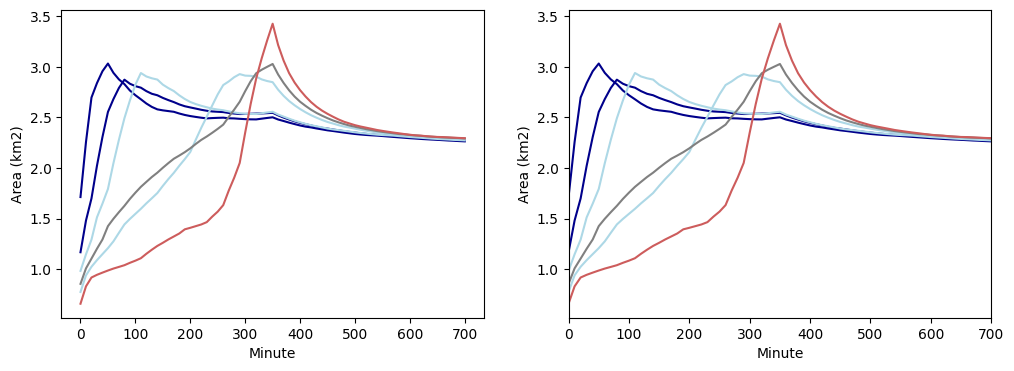

In [102]:
fig, ax = plt.subplots(ncols=2, figsize= (12,4))

colors_2mins = ['indianred', 'darkred']
colors_5mins = ['darkblue', 'darkblue', 'lightblue', 'lightblue', 'grey','indianred','darkred' ]
colors_test = ['darkblue', 'darkblue', 'lightblue', 'lightblue', 'grey','indianred','indianred','darkred','darkred' ]
  
        
for number, column in enumerate(df_allvalues.columns[:-1]):
      ax[0].plot(df_allvalues["minute"], df_allvalues[column], color = colors_5mins[number]); 
        
for number, column in enumerate(df_allvalues.columns[:-1]):
      ax[1].plot(df_allvalues["minute"], df_allvalues[column], color = colors_5mins[number])

        
ax[1].set_xlim(0,700)
ax[0].set_ylabel('Area (km2)')
ax[1].set_ylabel('Area (km2)')
ax[0].set_xlabel('Minute')
ax[1].set_xlabel('Minute');     

# fig.savefig("ProcessModelResults/Outputs/Figs/FloodedArea_OverTime.PNG")

### Not including areas of permanent water

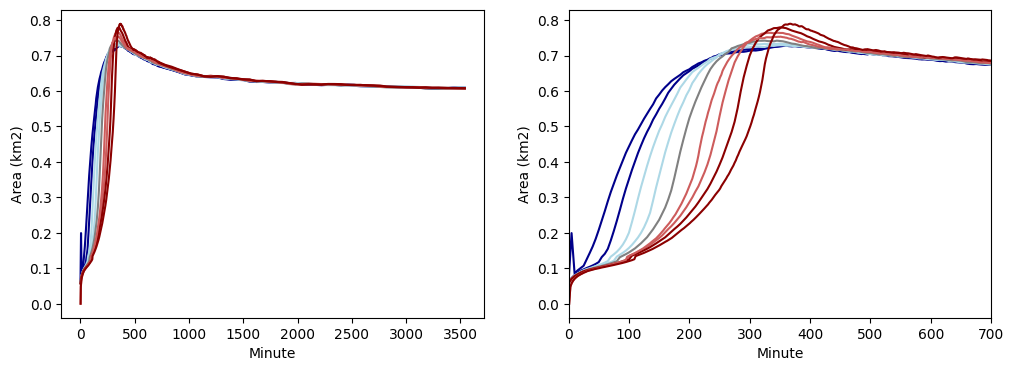

In [71]:
fig, ax = plt.subplots(ncols=2, figsize= (12,4))

colors_2mins = ['indianred', 'darkred']
colors_5mins = ['darkblue', 'darkblue', 'lightblue', 'lightblue', 'grey','indianred','darkred' ]
colors_test = ['darkblue', 'darkblue', 'lightblue', 'lightblue', 'grey','indianred','indianred','darkred','darkred' ]

for number, column in enumerate(df_5mins_notwater.columns[:-1]):
      ax[0].plot(df_5mins_notwater["minute"], df_5mins_notwater[column], color = colors_5mins[number]);           
        
for number, column in enumerate(df_2mins_notwater.columns[:-1]):
      ax[0].plot(df_2mins_notwater["minute"], df_2mins_notwater[column], color = colors_2mins[number]); 
        
for number, column in enumerate(df_test_notwater.columns[:-1]):
      ax[0].plot(df_test_notwater["minute"], df_test_notwater[column], color = colors_test[number]);    
        
        
for number, column in enumerate(df_5mins_notwater.columns[:-1]):
      ax[1].plot(df_5mins_notwater["minute"], df_5mins_notwater[column], color = colors_5mins[number])
        
for number, column in enumerate(df_2mins_notwater.columns[:-1]):
      ax[1].plot(df_2mins_notwater["minute"], df_2mins_notwater[column], color = colors_2mins[number]); 
        
for number, column in enumerate(df_test_notwater.columns[:-1]):
      ax[1].plot(df_test_notwater["minute"], df_test_notwater[column], color = colors_test[number]);     
        
ax[1].set_xlim(0,700)
ax[0].set_ylabel('Area (km2)')
ax[1].set_ylabel('Area (km2)')
ax[0].set_xlabel('Minute')
ax[1].set_xlabel('Minute');     

# fig.savefig("ProcessModelResults/Outputs/Figs/FloodedArea_OverTime.PNG")

### Only including cells over 10cm

In [13]:
df_5mins_over10cm

,6h_sp_fl_0.1,6h_sp_fl_0.2,6h_sp_fl_0.3,6h_sp_fl_0.4,6h_sp_c_0.5,6h_sp_bl_0.7,6h_sp_bl_0.8,minute
0,2.678670e-13,2.552470e-13,2.510590e-13,2.492190e-13,2.481790e-13,2.469060e-13,2.465760e-13,0
1,7.054820e-13,3.556480e-13,3.464210e-13,3.421170e-13,3.398580e-13,3.371020e-13,3.363770e-13,5
2,4.845010e-13,4.370300e-13,4.225730e-13,4.157080e-13,4.116420e-13,4.073370e-13,4.060330e-13,10
3,5.694920e-13,5.033000e-13,4.826740e-13,4.744300e-13,4.685890e-13,4.620010e-13,4.602390e-13,15
4,6.510170e-13,5.568280e-13,5.320860e-13,5.204810e-13,5.133050e-13,5.062980e-13,5.036030e-13,20
...,...,...,...,...,...,...,...,...
138,1.967388e-12,1.967503e-12,1.968199e-12,1.970643e-12,1.970970e-12,1.975396e-12,1.978366e-12,690
139,1.965606e-12,1.966377e-12,1.966722e-12,1.968329e-12,1.969835e-12,1.974239e-12,1.976425e-12,695
140,1.964535e-12,1.965012e-12,1.965516e-12,1.966293e-12,1.968053e-12,1.972042e-12,1.974772e-12,700
141,1.963582e-12,1.963701e-12,1.964210e-12,1.964632e-12,1.966388e-12,1.970150e-12,1.973265e-12,705


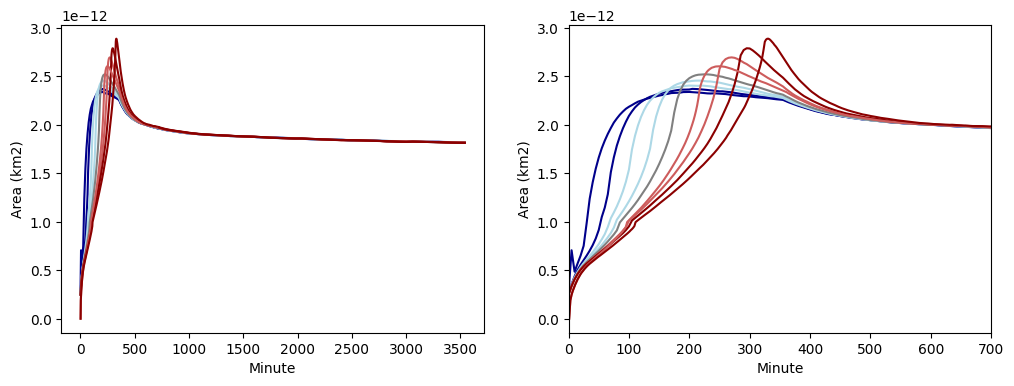

In [15]:
fig, ax = plt.subplots(ncols=2, figsize= (12,4))

colors_2mins = ['indianred', 'darkred']
colors_5mins = ['darkblue', 'darkblue', 'lightblue', 'lightblue', 'grey','indianred','darkred' ]
colors_test = ['darkblue', 'darkblue', 'lightblue', 'lightblue', 'grey','indianred','indianred','darkred','darkred' ]

for number, column in enumerate(df_5mins_over10cm.columns[:-1]):
      ax[0].plot(df_5mins_over10cm["minute"], df_5mins_over10cm[column], color = colors_5mins[number]);           
        
for number, column in enumerate(df_2mins_over10cm.columns[:-1]):
      ax[0].plot(df_2mins_over10cm["minute"], df_2mins_over10cm[column], color = colors_2mins[number]); 
        
for number, column in enumerate(df_test_over10cm.columns[:-1]):
      ax[0].plot(df_test_over10cm["minute"], df_test_over10cm[column], color = colors_test[number]);    
        
        
for number, column in enumerate(df_5mins_over10cm.columns[:-1]):
      ax[1].plot(df_5mins_over10cm["minute"], df_5mins_over10cm[column], color = colors_5mins[number])
        
for number, column in enumerate(df_2mins_over10cm.columns[:-1]):
      ax[1].plot(df_2mins_over10cm["minute"], df_2mins_over10cm[column], color = colors_2mins[number]); 
        
for number, column in enumerate(df_test_over10cm.columns[:-1]):
      ax[1].plot(df_test_over10cm["minute"], df_test_over10cm[column], color = colors_test[number]);     
        
ax[1].set_xlim(0,700)
ax[0].set_ylabel('Area (km2)')
ax[1].set_ylabel('Area (km2)')
ax[0].set_xlabel('Minute')
ax[1].set_xlabel('Minute');     

# fig.savefig("ProcessModelResults/Outputs/Figs/FloodedArea_OverTime.PNG")